In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import scipy.io
import scipy
plt.figure(figsize=(20,5));

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<Figure size 1440x360 with 0 Axes>

In [2]:
working_dir = "C:\\Users\\Aniket3.Kulkarni\\Desktop\\battery"

In [3]:
gen = os.walk(working_dir)

In [4]:
dirs = next(os.walk('.'))[1]

In [5]:
dirs[0]

'.ipynb_checkpoints'

In [6]:
mat = scipy.io.loadmat(dirs[1]+'\\'+'RW9.mat')
mat = mat['data'][0][0][0][0]
df = pd.DataFrame(mat)
ref_discharge = df[df['comment'] == 'reference discharge']
ref_discharge.head()

,comment,type,time,relativeTime,voltage,current,temperature,date
1,[reference discharge],[D],"[[10509.699999999999, 10519.7, 10529.7, 10539....","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[4.113, 4.099, 4.091, 4.085, 4.079, 4.075, 4....","[[1.004, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1....","[[22.10602, 22.05919, 22.04357, 22.01235, 21.9...",[06-Jan-2014 16:31:49]
3,[reference discharge],[D],"[[28575.879999999997, 28585.88, 28595.88, 2860...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[4.113, 4.099, 4.091, 4.085, 4.079, 4.074, 4....","[[1.003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1....","[[22.55875, 22.55875, 22.57436, 22.60559, 22.6...",[06-Jan-2014 21:32:56]
3031,[reference discharge],[D],"[[427288.81999999995, 427298.82, 427308.82, 42...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[4.11, 4.094, 4.085, 4.077, 4.071, 4.066, 4.0...","[[1.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0, ...","[[22.63681, 22.63681, 22.65242, 22.66803, 22.6...",[11-Jan-2014 12:30:19]
3033,[reference discharge],[D],"[[446909.27, 446919.26999999996, 446929.27, 44...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[4.109, 4.093, 4.084, 4.076, 4.07, 4.065, 4.0...","[[1.006, 0.999, 0.999, 1.0, 1.0, 1.0, 1.001, 1...","[[22.15285, 22.16847, 22.18408, 22.2153, 22.23...",[11-Jan-2014 17:57:21]
6057,[reference discharge],[D],"[[830934.71, 830944.71, 830954.7100000001, 830...","[[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60....","[[4.106, 4.088, 4.078, 4.071, 4.064, 4.058, 4....","[[1.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1....","[[21.73134, 21.73134, 21.76257, 21.77818, 21.7...",[16-Jan-2014 04:50:19]


In [7]:
def get_timeline(name): 
    mat = scipy.io.loadmat(name)
    mat = mat['data'][0][0][0][0]
    df = pd.DataFrame(mat)
    ref_discharge = df[df['comment'] == 'reference discharge']
    time = [str(i[0]) for i in ref_discharge['date']]
    ref_discharge.index = pd.to_datetime(time)

    return ref_discharge.index.max(), ref_discharge.index.min(), ref_discharge.index.max() - ref_discharge.index.min()

In [8]:
def get_capacity(name): 
    mat = scipy.io.loadmat(name)
    mat = mat['data'][0][0][0][0]
    df = pd.DataFrame(mat)
    ref_discharge = df[df['comment'] == 'reference discharge']
    time = np.array([i[0][-1] for i in ref_discharge['time']])
    # ref_discharge.index = pd.to_datetime(time)

    cap = []
    for i, row in ref_discharge.iterrows():
        cap.append(np.trapz(row['current'][0], row['relativeTime'][0]))
    cap = np.array(cap/max(cap))
    cap, time = cap[np.where(cap>0.1)], time[np.where(cap>0.1)]
    #cap, time = cap[np.where(time>1.25e6)], time[np.where(time>1.25e6)]
    #cap = np.interp(np.linspace(0, 1.25e6, 10001), time, cap)
    # cap, time = cap[cap>=0.75], time[cap>=0.75]
    return cap, time

In [9]:
NUM_STEPS = 1000
cap_mat = np.zeros((20, NUM_STEPS))
index_ = 0
time = np.linspace(0,1e7,NUM_STEPS)
for dir in dirs:
    if dir != '.ipynb_checkpoints':
        for file in os.listdir(dir):
            if file not in [f'RW2{i}.mat' for i in range(1,9)]:
                print(file, dir)
                capacity, t = get_capacity(dir+'\\'+ file)
                time = np.linspace(t[0], t[-1], NUM_STEPS)
                capacity = np.interp(time, t, capacity)
                
                capacity, t = capacity[time<1.25e7], time[time<1.25e7]
                time = np.linspace(t[0], 1.25e7, NUM_STEPS)
                capacity = np.interp(time, t, capacity)
                cap_mat[index_,:] = capacity
                index_+=1

RW10.mat Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post
RW11.mat Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post
RW12.mat Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post
RW9.mat Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post
RW3.mat Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post
RW4.mat Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post
RW5.mat Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post
RW6.mat Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post
RW1.mat Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post
RW2.mat Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post
RW7.mat Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post
RW8.mat Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post
RW17.mat RW_Skewed_High_Room_Temp_DataSet_2Post
RW18.mat RW_Skewed_High_Room_Temp_DataSet_2Post
RW19.mat RW_Skewed_High_Room_Temp_Dat

In [10]:
cap_mat.shape

(20, 1000)

In [11]:
def split_data(series, input_size=100, output_size=5):
    total_shape = input_size+output_size
    slices_ = np.zeros((total_shape,1))
    
    for ibat, battery in enumerate(series):
        for slice_ in range(battery.shape[0]):
            if battery[slice(slice_, slice_+total_shape, 1)].shape[0] < total_shape:
                break
            slices_ = np.c_[slices_, battery[slice(slice_, slice_+total_shape, 1)].reshape(-1,1)]
    slices_ = slices_[:,1:].T
    return slices_[..., np.newaxis]

In [34]:
in_seq_size, label_seq_size = 200, 1
windows = split_data(cap_mat, in_seq_size,label_seq_size)

In [35]:
windows.shape

(16000, 201, 1)

Text(0, 0.5, 'Normalized capacity')

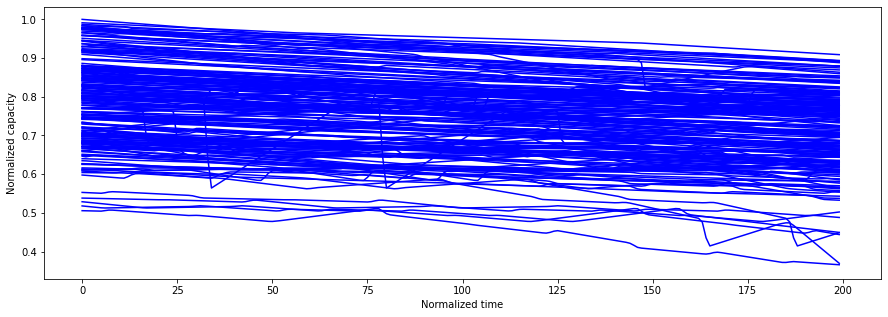

In [36]:
plt.figure(figsize=(15,5))
for i in np.random.choice(np.arange(windows.shape[0]),200):
    plt.plot(np.arange(in_seq_size),windows[i, :in_seq_size],'b')
    plt.plot(np.arange(label_seq_size)+in_seq_size,windows[i, in_seq_size:],'--r')
plt.xlabel('Normalized time')
plt.ylabel('Normalized capacity')

In [37]:
X, y = windows[:, :in_seq_size], windows[:, in_seq_size:]

In [38]:
X.shape, y.shape

((16000, 200, 1), (16000, 1, 1))

In [39]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1)

In [40]:
X_train.shape, X_valid.shape, X_test.shape , y_train.shape, y_valid.shape, y_test.shape

((12960, 200, 1),
 (1440, 200, 1),
 (1600, 200, 1),
 (12960, 1, 1),
 (1440, 1, 1),
 (1600, 1, 1))

## Naive Baseline

In [41]:
def baseline(X):
    return X[:, -1]

In [42]:
y_pred = baseline(X_valid)
np.mean(keras.losses.mean_squared_error(y_pred, y_valid))

0.019934709987281737

In [43]:
def plot_preds(x, y, y_pred):
    plt.plot(np.arange(x.shape[0]), x, 'g')
    plt.plot(np.arange(y.shape[0])+x.shape[0], y, 'k', label='Actual')
    plt.plot(np.arange(y.shape[0])+x.shape[0], y_pred, '-ob', label='Prediction')
    plt.legend()
    plt.grid(True)

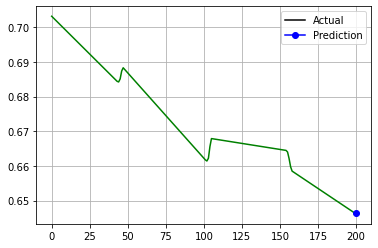

In [44]:
i = np.random.choice(np.arange(X_valid.shape[0]))
plot_preds(X_valid[i], y_valid[i], y_pred[i])

## Dense MLP 

In [45]:
fc = keras.Sequential([
    keras.layers.Flatten(input_shape=[in_seq_size]),
    keras.layers.Dense(1)
])

In [46]:
fc.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [47]:
fc.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.mean_squared_error)

In [48]:
hist = fc.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/20
405/405 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 5.5238e-04
Epoch 2/20
405/405 [==============================] - 0s 940us/step - loss: 5.0826e-04 - val_loss: 5.4978e-04
Epoch 3/20
405/405 [==============================] - 0s 911us/step - loss: 5.0300e-04 - val_loss: 5.4185e-04
Epoch 4/20
405/405 [==============================] - 0s 953us/step - loss: 4.9401e-04 - val_loss: 5.3460e-04
Epoch 5/20
405/405 [==============================] - 0s 1ms/step - loss: 4.8629e-04 - val_loss: 5.4577e-04
Epoch 6/20
405/405 [==============================] - 0s 961us/step - loss: 4.7296e-04 - val_loss: 5.0236e-04
Epoch 7/20
405/405 [==============================] - 0s 982us/step - loss: 4.6609e-04 - val_loss: 4.8334e-04
Epoch 8/20
405/405 [==============================] - 0s 908us/step - loss: 4.4905e-04 - val_loss: 5.2180e-04
Epoch 9/20
405/405 [==============================] - 0s 938us/step - loss: 4.3375e-04 - val_loss: 4.6021e-04
Epoch 10/20
405/40

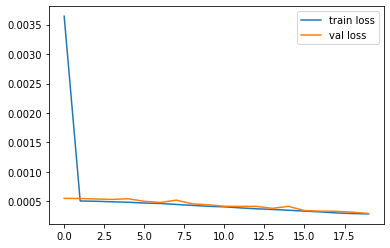

In [49]:
plt.plot(hist.history['loss'], label = 'train loss')
plt.plot(hist.history['val_loss'], label = 'val loss')
plt.legend()

In [50]:
y_pred = fc.predict(X_valid)
np.sqrt(mean_squared_error(y_pred, y_valid[:,:,0]))

0.01720744489150512

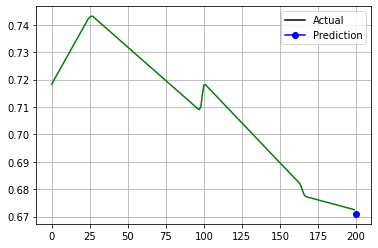

In [51]:
i = np.random.choice(np.arange(X_valid.shape[0]))
plot_preds(X_valid[i], y_valid[i], y_pred[i])

## RNNs

In [52]:
rnn = keras.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

In [53]:
rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [54]:
rnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.mean_squared_error)

In [55]:
hist = rnn.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/20
405/405 [==============================] - 9s 21ms/step - loss: 0.0817 - val_loss: 0.0051
Epoch 2/20
405/405 [==============================] - 8s 20ms/step - loss: 0.0034 - val_loss: 6.3400e-04
Epoch 3/20
405/405 [==============================] - 8s 21ms/step - loss: 5.0052e-04 - val_loss: 3.1180e-04
Epoch 4/20
405/405 [==============================] - 8s 21ms/step - loss: 2.3380e-04 - val_loss: 1.6425e-04
Epoch 5/20
405/405 [==============================] - 8s 20ms/step - loss: 1.8737e-04 - val_loss: 1.1859e-04
Epoch 6/20
405/405 [==============================] - 8s 21ms/step - loss: 1.5088e-04 - val_loss: 1.0811e-04
Epoch 7/20
405/405 [==============================] - 8s 21ms/step - loss: 1.3167e-04 - val_loss: 1.8128e-04
Epoch 8/20
405/405 [==============================] - 8s 21ms/step - loss: 1.1891e-04 - val_loss: 1.4569e-04
Epoch 9/20
405/405 [==============================] - 8s 21ms/step - loss: 9.8130e-05 - val_loss: 1.0826e-04
Epoch 10/20
405/405 [==========

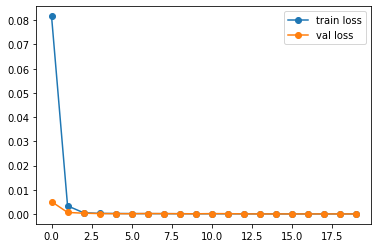

In [56]:
plt.plot(hist.history['loss'], '-o', label = 'train loss')
plt.plot(hist.history['val_loss'], '-o', label = 'val loss')
plt.legend()

In [90]:
y_pred = rnn.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_pred, y_valid))

0.019845666191657913

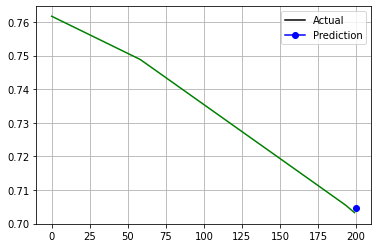

In [104]:
i = np.random.choice(np.arange(X_valid.shape[0]))
plot_preds(X_valid[i], y_valid[i], y_pred[i])

## Forecasting several timesteps ahead

In [59]:
in_seq_size, label_seq_size = 200, 20
windows_new = split_data(cap_mat, in_seq_size,label_seq_size)

In [60]:
X_new, y_new = windows_new[:, :in_seq_size], windows_new[:, in_seq_size:]
X_new.shape, y_new.shape

((15620, 200, 1), (15620, 20, 1))

In [61]:
def multi_step_predict(X_new, y_new, model):
    X = X_new
    for time in range(label_seq_size):
        y_pred = model.predict(X[:,time:,:])
        X = np.c_[X[...,0], y_pred][...,np.newaxis]
    Y_pred = X[:,in_seq_size:]
    return Y_pred

In [83]:
Y_pred = multi_step_predict(X_new, y_new, rnn)

Text(0.5, 1.0, '3933')

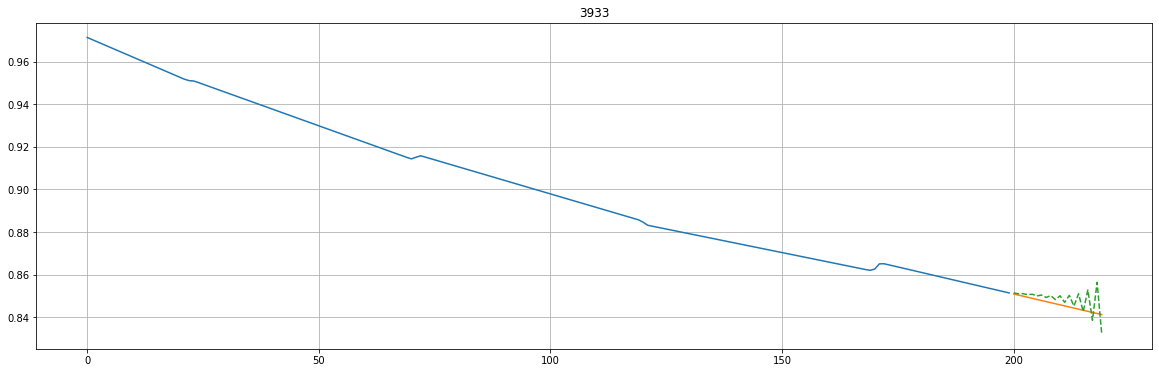

In [88]:
plt.figure(figsize=(20,6))
i = np.random.choice(np.arange(X_new.shape[0]))
plt.plot(X_new[i])
plt.plot(np.arange(label_seq_size)+in_seq_size, y_new[i])
plt.plot(np.arange(label_seq_size)+in_seq_size, Y_pred[i], '--')
plt.grid(True)
plt.title(i)

In [64]:
np.mean(keras.losses.mean_squared_error(Y_pred, y_new))

0.0032912948797251076

## Seq2Vec RNN

In [65]:
seq2vec = keras.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(10),
    keras.layers.Dense(label_seq_size)
])

In [66]:
seq2vec.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 20)                220       
                                                                 
Total params: 550
Trainable params: 550
Non-trainable params: 0
_________________________________________________________________


In [67]:
seq2vec.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.mean_squared_error)

In [68]:
hist = seq2vec.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/20
405/405 [==============================] - 19s 44ms/step - loss: 0.3435 - val_loss: 0.1942
Epoch 2/20
405/405 [==============================] - 18s 45ms/step - loss: 0.1231 - val_loss: 0.0663
Epoch 3/20
405/405 [==============================] - 19s 47ms/step - loss: 0.0406 - val_loss: 0.0226
Epoch 4/20
405/405 [==============================] - 18s 46ms/step - loss: 0.0169 - val_loss: 0.0128
Epoch 5/20
405/405 [==============================] - 18s 44ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 6/20
405/405 [==============================] - 18s 44ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 7/20
405/405 [==============================] - 19s 48ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 8/20
405/405 [==============================] - 19s 47ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 9/20
405/405 [==============================] - 19s 47ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 10/20
405/405 [==============================] - 19s 47ms/step - loss: 0.003

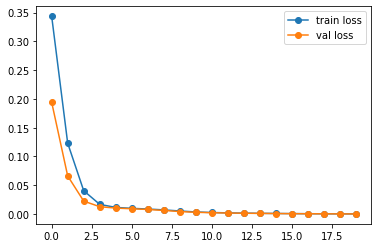

In [69]:
plt.plot(hist.history['loss'], '-o', label = 'train loss')
plt.plot(hist.history['val_loss'], '-o', label = 'val loss')
plt.legend()

In [70]:
y_pred = seq2vec.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_pred, y_valid))

0.0191629574300461

Text(0.5, 1.0, '15181')

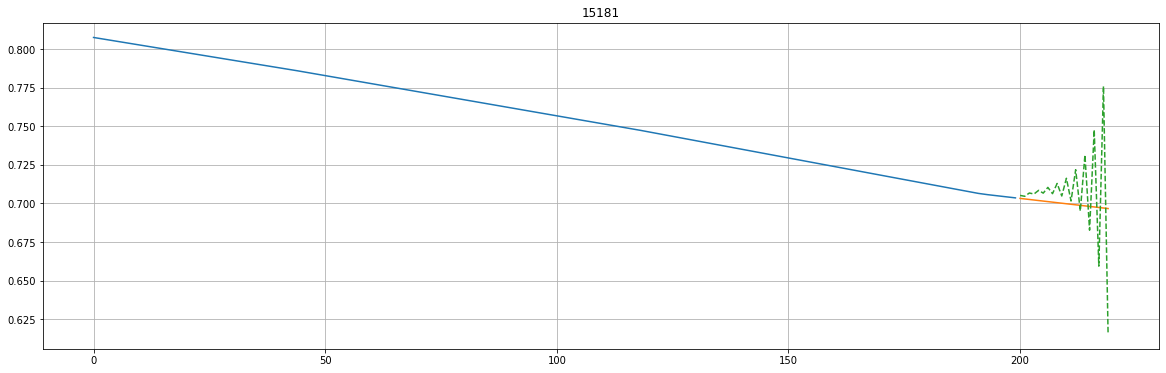

In [82]:
plt.figure(figsize=(20,6))
i = np.random.choice(np.arange(X_new.shape[0]))
plt.plot(X_new[i])
plt.plot(np.arange(label_seq_size)+in_seq_size, y_new[i])
plt.plot(np.arange(label_seq_size)+in_seq_size, Y_pred[i], '--')
plt.grid(True)
plt.title(i)

## Skip connection to Seq2vec model

In [110]:
input_ = keras.layers.Input((None,1), dtype=tf.float32)
l = keras.layers.SimpleRNN(10, return_sequences=True)(input_)
l = keras.layers.SimpleRNN(10)(l)

l1 = keras.layers.Dense(10)(input_)
l1 = keras.layers.Dense(label_seq_size)(l1+input_)
seq2vec_res = keras.models.Model(inputs=[input_], outputs=[l1])

In [111]:
seq2vec_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 dense_6 (Dense)                (None, None, 10)     20          ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, None, 10)    0           ['dense_6[0][0]',                
 mbda)                                                            'input_2[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, None, 20)     220         ['tf.__operators__.add_1[0]

In [112]:
keras.utils.plot_model(seq2vec_res)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [133]:
seq2vec_res.compile(optimizer=keras.optimizers.Adam(1e-5), loss=keras.losses.mean_squared_error)

In [134]:
hist = seq2vec_res.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
405/405 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2/50
405/405 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/50
405/405 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/50
405/405 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/50
405/405 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/50
405/405 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/50
 25/405 [>.............................] - ETA: 0s - loss: 0.0013

KeyboardInterrupt: 

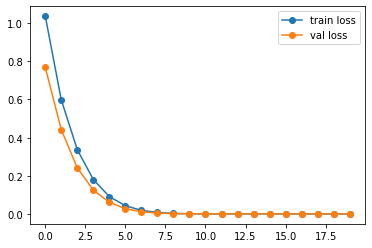

In [135]:
plt.plot(hist.history['loss'], '-o', label = 'train loss')
plt.plot(hist.history['val_loss'], '-o', label = 'val loss')
plt.legend()

In [136]:
y_pred = seq2vec_res.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_pred, y_valid))

0.001474836848161032

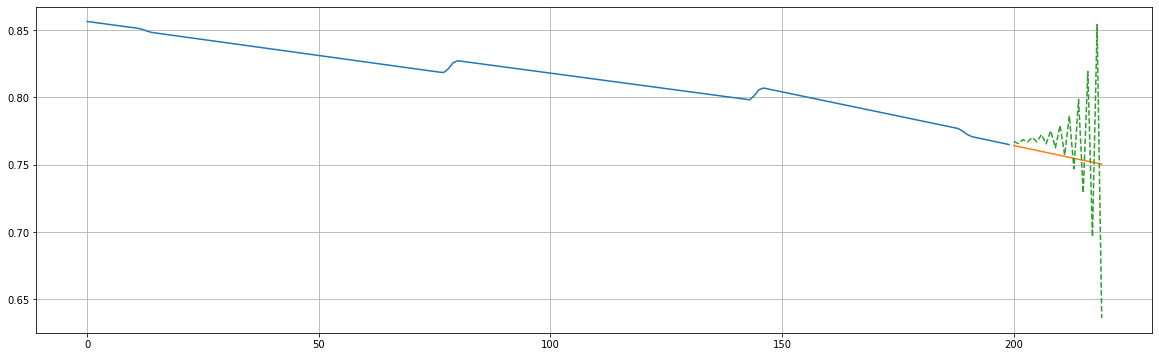

In [162]:
plt.figure(figsize=(20,6))
i = np.random.choice(np.arange(X_new.shape[0]))
plt.plot(X_new[i])
plt.plot(np.arange(label_seq_size)+in_seq_size, y_new[i])
plt.plot(np.arange(label_seq_size)+in_seq_size, Y_pred[i], '--')
plt.grid(True)